In [1]:
from cathedral_rl import cathedral_v0 
from cathedral_rl.game.board import Board 
 
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
from tqdm import tqdm 

### Replay Buffer

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        return state, action, reward, next_state, done, action_mask, next_action_mask
        
    def __len__(self):
        return len(self.buffer)    


In [3]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity 
        self.tree = np.zeros(2 * capacity - 1) 
        self.data = [None] * capacity  
        self.write = 0  
        self.n_entries = 0 

    def add(self, priority, data):
        idx = self.write + self.capacity - 1  
        self.data[self.write] = data
        self.update(idx, priority)
        
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf_idx = idx
                break
            else:
                if s <= self.tree[left]:
                    idx = left
                else:
                    s -= self.tree[left]
                    idx = right
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_priority(self):
        return self.tree[0]


In [4]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)

    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        max_priority = np.max(self.tree.tree[-self.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(max_priority, transition)

    def sample(self, batch_size, beta=0.4):
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total_priority / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append(data)
            priorities.append(p)
            idxs.append(idx)

        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        total = self.tree.total_priority
        probs = np.array(priorities) / total
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max() 
        
        return state, action, reward, next_state, done, action_mask, next_action_mask, idxs, weights

    def update_priorities(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority ** self.alpha)

    def __len__(self):
        return self.tree.n_entries


### Model

In [5]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        # observations : (10, 10, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),             
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),              
            nn.ReLU(),
            nn.Flatten()
        )
        
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, n_actions)
        )
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  
        x = self.conv(x)
        x = self.fc(x)
        return x


### Training

#### Hyperparameters

In [13]:
num_episodes = 700
buffer_capacity = 3000
treshold_penalize_illegal = 0
penalize_value = 10
batch_size = 64
gamma = 0.95
learning_rate = 1e-3
board_size = 6

factor_illegal_action = 1
prioritized_replay_buffer = True

parameters_updates = 10   
target_update_freq = 20    
opponent_update_freq = 1

epsilon_start = 0.3
epsilon_final = 0.1
epsilon_decay = 200  

agents = ["player_0", "player_1"]
method = "boltzmann" # "eps_greedy" or "boltzmann"

per_move_rewards=True
final_reward_score_difference=True

name = f'{per_move_rewards}_{final_reward_score_difference}_episodes:{num_episodes}_buffer:{buffer_capacity}_prioritized:{prioritized_replay_buffer}_batch_size:{batch_size}_gamma:{gamma}_target_update:{target_update_freq}_opponent_freq:{opponent_update_freq}_treshold_penalize:{treshold_penalize_illegal}_penalize_value:{penalize_value}_eps{epsilon_start}to{epsilon_final}with{epsilon_decay}_{method}'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')

def epsilon_by_episode(episode):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-episode / epsilon_decay)

def temperature_by_episode(episode): # not implemented yet
    return 1

device : cuda


#### Functions

In [14]:
def create_networks(obs_shape, n_actions):
    policy_net = DQN(obs_shape, n_actions).to(device)
    
    target_net = DQN(obs_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    opponent_net = DQN(obs_shape, n_actions).to(device)
    opponent_net.load_state_dict(policy_net.state_dict())
    
    return policy_net, target_net, opponent_net

def compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor): # Double DQN
    with torch.no_grad():
        next_q_policy = policy_net(next_states_tensor)  # [batch_size, n_actions]
        next_q_policy[~next_action_masks_tensor] = -1e8
        next_actions = next_q_policy.argmax(dim=1, keepdim=True)  # [batch_size, 1]

        next_q_target = target_net(next_states_tensor)
        next_q_target[~next_action_masks_tensor] = -1e8
        
        next_q_values = next_q_target.gather(1, next_actions).squeeze(1)

        mask_sum = next_action_masks_tensor.sum(dim=1)
        next_q_values[mask_sum == 0] = 0.0

        # target_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)
        target_q_values = rewards_tensor - gamma * next_q_values * (1 - dones_tensor)
        return target_q_values

In [15]:
def select_action_dqn(model, obs, action_mask, legal_moves, episode, device, method, verbose=False):
    model.eval()
    with torch.no_grad():
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 10, 10, 5)
        q_values = model(obs_tensor).squeeze(0)  # (n_actions,)
        
        if method == 'eps_greedy':
            epsilon = epsilon_by_episode(episode)
            if random.random() < epsilon:
                first_action = random.choice(legal_moves)
                action = first_action
            else:
                first_action = torch.argmax(q_values).item()
                mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
                q_values[~mask] = -1e8
                action = torch.argmax(q_values).item()
        
        elif method == 'boltzmann':
            temperature = temperature_by_episode(episode)
            first_action = torch.argmax(q_values).item()
            mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
            q_values[~mask] = -1e8
            action = torch.argmax(q_values).item()
            probabilities = F.softmax(q_values / temperature, dim=-1)
            action = torch.multinomial(probabilities, num_samples=1).item()
            if mask[first_action]:
                first_action = action
        
    model.train()
    return first_action, action

In [16]:
def train_dqn(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=per_move_rewards, final_reward_score_difference=final_reward_score_difference)
    env.reset()
    
    enter_train = False
    n_actions = env.action_space('player_0').n
    print(f'n_actions : {n_actions}')
    obs_shape = env.observe('player_0')["observation"].shape

    policy_net, target_net, _ = create_networks(obs_shape, n_actions)
    
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    if prioritized_replay_buffer:
        replay_buffer = PrioritizedReplayBuffer(buffer_capacity, alpha=0.6)
    else:
       replay_buffer = ReplayBuffer(buffer_capacity) 
       
    list_reward = []
    list_epsilon = []
    list_loss = []      # To store average loss per episode
    list_steps = []     # To store number of steps per episode
    list_winner = []    # To store the winner result (1 win, 0.5 draw, 0 loss)
    list_legal_actions = []
    list_episode_ended = []
    list_legal_moves_possible = []
    win_count = 0

    for episode in range(num_episodes):
        if episode == treshold_penalize_illegal:
            print("STOP penalizing illegal actions")
        env.reset()
        list_agents = env.agents
        total_reward = 0
        legal_actions = 0
        losses = []
        episode_ended = True
        steps = 0
        while env.agents:
            steps += 1
            current_agent = env.agent_selection
            opponent_agent = 'player_0' if current_agent == 'player_1' else 'player_1'
            
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            state = observation["observation"]
            action_mask = observation["action_mask"]
            
            first_action, action = select_action_dqn(policy_net, state, action_mask, legal_moves, episode, device, method=method)
            
            legal_action = first_action == action
            env.step(action)
            reward = env.rewards[current_agent]
            # reward -= factor_illegal_action * not_legal_action # Penalize illegal actions
            
            if episode > treshold_penalize_illegal:
                legal_action = True
            
            if legal_action:
                legal_actions += 1
                total_reward += reward
            else:
                total_reward -= 10
                
            if current_agent in env.agents and legal_action:
                next_obs = env.observe(opponent_agent)
                next_state = next_obs["observation"]
                next_action_mask = next_obs["action_mask"]
                done_flag = 0
            else:
                next_state = np.zeros_like(state)
                next_action_mask = np.zeros_like(action_mask)
                done_flag = 1
            
            if legal_action:
                replay_buffer.push(state, action, reward, next_state, done_flag, action_mask, next_action_mask)

            else:
                replay_buffer.push(state, first_action, -10, next_state, done_flag, action_mask, next_action_mask)
                
            
            if len(replay_buffer) >= batch_size:
                enter_train = True
                
                for _ in range(parameters_updates):  
                    if prioritized_replay_buffer:
                        states, actions, rewards, next_states, dones, action_masks, next_action_masks, _, _ = replay_buffer.sample(batch_size)
                    else:
                        states, actions, rewards, next_states, dones, action_masks, next_action_masks = replay_buffer.sample(batch_size)
                    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                    actions_tensor = torch.tensor(actions, dtype=torch.long).to(device)
                    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                    next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                    dones_tensor = torch.tensor(dones, dtype=torch.float32).to(device)
                    next_action_masks_tensor = torch.tensor(next_action_masks, dtype=torch.bool).to(device)
                    
                    q_values = policy_net(states_tensor)
                    q_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    
                    target_q_values = compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor)
                
                    loss = nn.MSELoss()(q_values, target_q_values)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())
                    
            if not legal_action:
                episode_ended = False
                break
                    
        list_legal_actions.append(legal_actions)
        list_reward.append(total_reward)
        list_steps.append(steps)
        list_epsilon.append(epsilon_by_episode(episode))
        
        if losses:
            avg_loss = sum(losses) / len(losses)
        else:
            avg_loss = 0
        list_loss.append(avg_loss)
        

        winner = env.winner
        if winner == -1:
            win_count += 0.5
            list_winner.append(0.5)
        else:
            if list_agents[winner] == 'player_0':  # "player_0" wins
                win_count += 1
                list_winner.append(1)
            else:
                list_winner.append(0)

        if episode_ended:
            list_episode_ended.append(1)
        else:
            list_episode_ended.append(0)
        
        if enter_train:
            print(f"Episode {episode+1}/{num_episodes} - Reward total: {total_reward:.2f} - Legal Actions : {legal_actions} - Loss: {sum(losses)/(len(losses)+1e-8):.4f} - Winner: {winner} - Ep Ended: {episode_ended} - Epsilon: {epsilon_by_episode(episode):.2f}")
        
        if (episode+1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print("Update target_net")
            
        # if (episode+1) % opponent_update_freq == 0:
        #     policy_net_checkpoints.append(policy_net.state_dict())
        #     opponent_net.load_state_dict(policy_net.state_dict())
        #     # print("Update opponent_net")    
        
    env.close()

    torch.save({
        'model_state_dict': policy_net.state_dict(),
        'list_reward': list_reward,
        'list_epsilon': list_epsilon,
        'list_loss': list_loss,
        'list_steps': list_steps,
        'list_winner': list_winner,
        'list_legal_actions': list_legal_actions,
        'list_episode_ended': list_episode_ended,
        'win_rate': win_count/num_episodes
    }, f"model_weights_DQN/{name}.pth")

    
    print(f'Winrate : {win_count/num_episodes}')
    
    return list_reward, list_epsilon, list_loss, list_steps, list_winner

In [17]:
list_reward, list_epsilon, list_loss, list_steps, list_winner = train_dqn('TEST')

n_actions : 857
STOP penalizing illegal actions
Episode 6/700 - Reward total: -20.00 - Legal Actions : 12 - Loss: 3.0207 - Winner: 1 - Ep Ended: True - Epsilon: 0.30
Episode 7/700 - Reward total: -19.00 - Legal Actions : 13 - Loss: 0.3354 - Winner: 0 - Ep Ended: True - Epsilon: 0.29
Episode 8/700 - Reward total: -17.00 - Legal Actions : 13 - Loss: 0.0268 - Winner: 1 - Ep Ended: True - Epsilon: 0.29
Episode 9/700 - Reward total: -11.00 - Legal Actions : 14 - Loss: 0.0309 - Winner: 1 - Ep Ended: True - Epsilon: 0.29
Episode 10/700 - Reward total: -17.00 - Legal Actions : 13 - Loss: 0.0792 - Winner: 0 - Ep Ended: True - Epsilon: 0.29
Episode 11/700 - Reward total: -24.00 - Legal Actions : 13 - Loss: 0.0359 - Winner: 0 - Ep Ended: True - Epsilon: 0.29
Episode 12/700 - Reward total: -14.00 - Legal Actions : 13 - Loss: 0.0144 - Winner: 1 - Ep Ended: True - Epsilon: 0.29
Episode 13/700 - Reward total: -19.00 - Legal Actions : 14 - Loss: 0.0233 - Winner: 1 - Ep Ended: True - Epsilon: 0.29
Epis

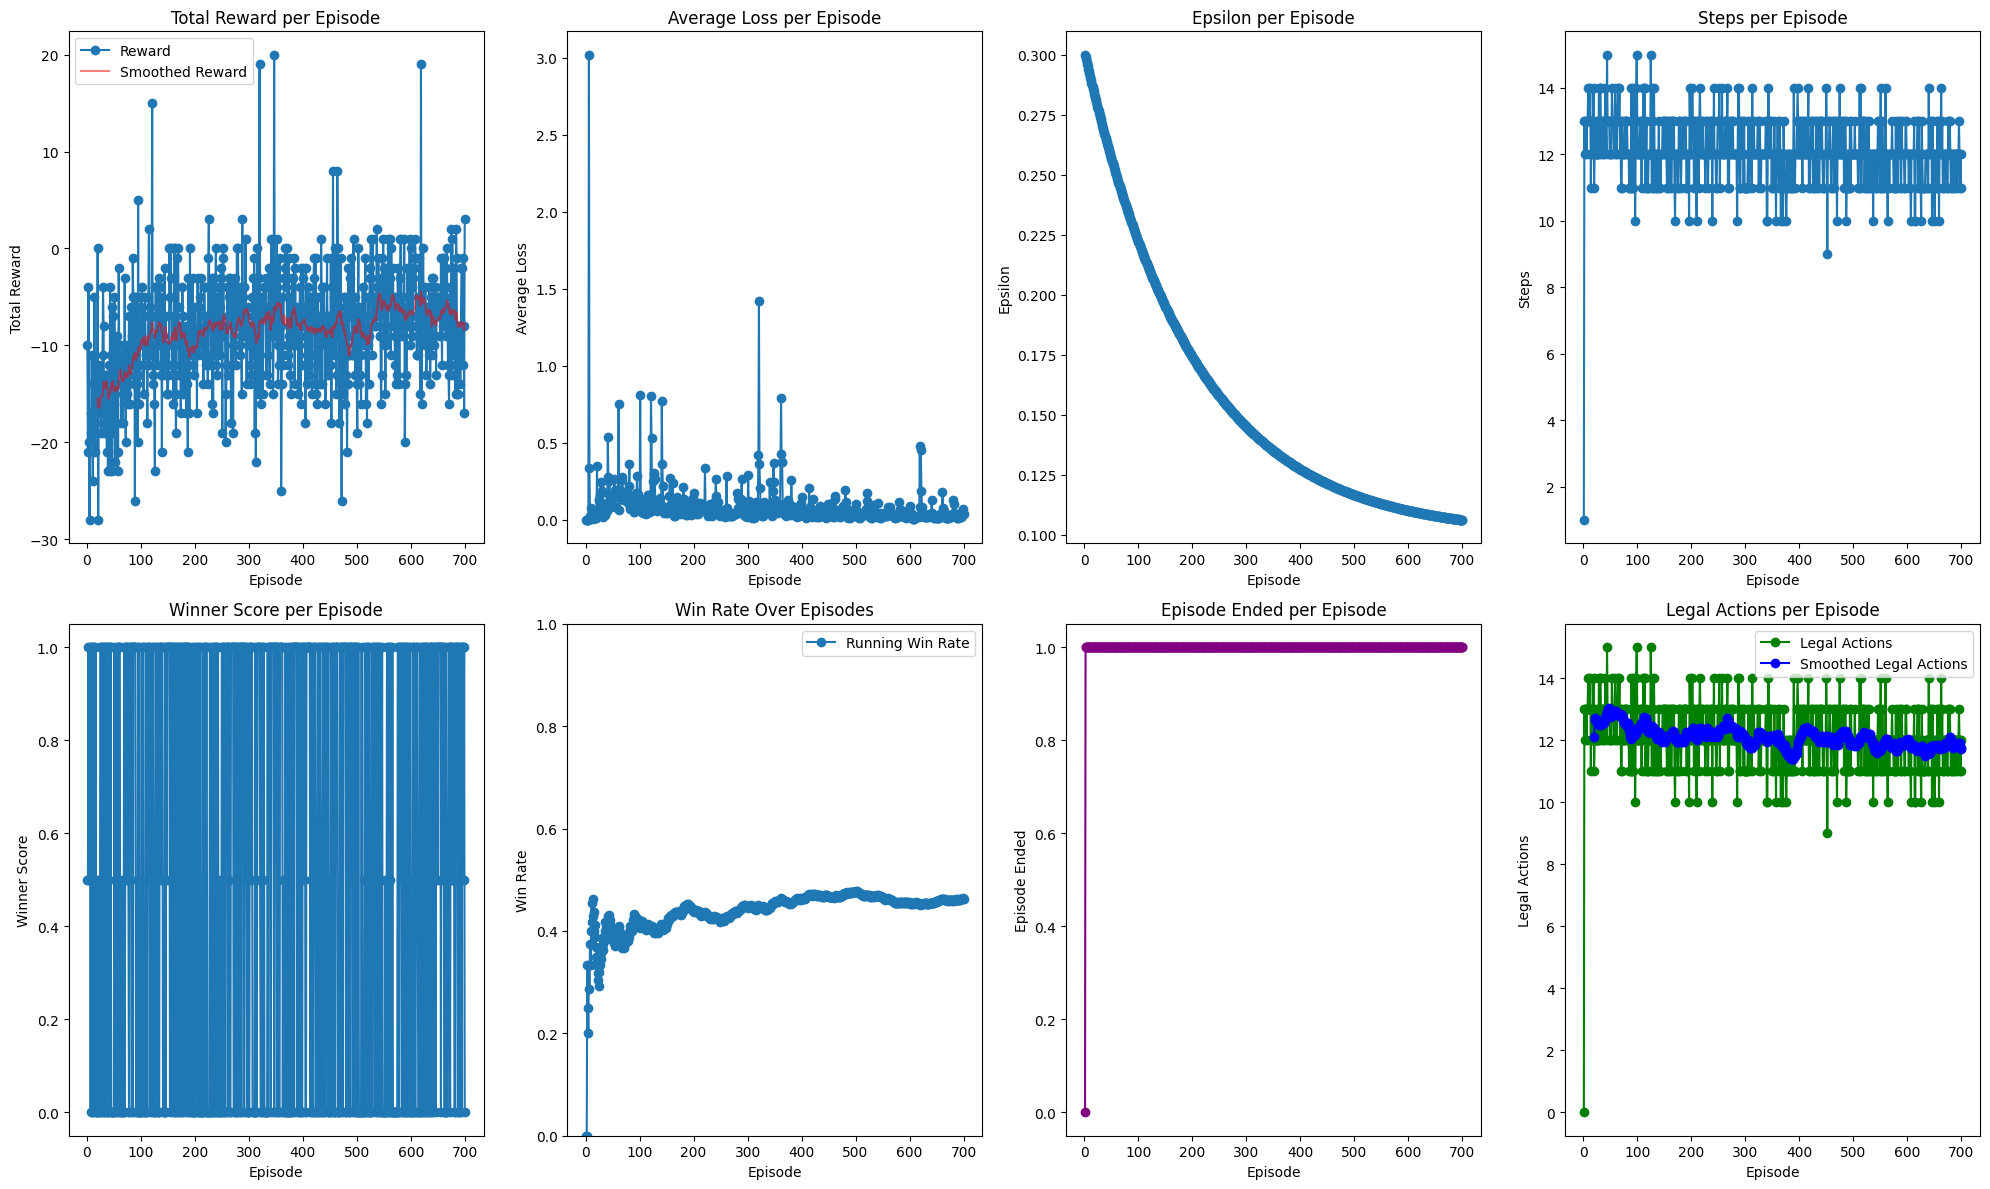

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Autorise les scalaires de numpy dans la sérialisation de torch
torch.serialization.add_safe_globals(["numpy._core.multiarray.scalar"])

# Chargement du fichier contenant les poids
data = torch.load("model_weights_DQN/TEST.pth", weights_only=False)

# Extraction des listes pour le plotting
list_reward          = data['list_reward']
list_epsilon         = data['list_epsilon']
list_loss            = data['list_loss']
list_steps           = data['list_steps']
list_winner          = data['list_winner']
list_episode_ended   = data['list_episode_ended']
list_legal_actions   = data['list_legal_actions']

# Création de l'axe x (les épisodes)
episodes = np.arange(1, len(list_reward) + 1)

# Calcul de la moyenne lissée des rewards (moyenne glissante)
window_size = 20  # taille de la fenêtre pour le lissage (à ajuster selon vos données)

# Calcul de la moyenne lissée pour list_legal_actions
smoothed_legal_actions = np.convolve(list_legal_actions, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = np.convolve(list_reward, np.ones(window_size)/window_size, mode='valid')

# Création d'une figure avec 8 subplots (2 lignes x 4 colonnes)
plt.figure(figsize=(20, 12))

# 1. Total Reward per Episode avec moyenne lissée
plt.subplot(2, 4, 1)
plt.plot(episodes, list_reward, marker='o', linestyle='-', label="Reward")
plt.plot(episodes[window_size-1:], smoothed_rewards, alpha=0.5, linestyle='-', color='red', label="Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

# 2. Average Loss per Episode
plt.subplot(2, 4, 2)
plt.plot(episodes, list_loss, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Average Loss")
plt.title("Average Loss per Episode")

# 3. Epsilon per Episode
plt.subplot(2, 4, 3)
plt.plot(episodes, list_epsilon, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon per Episode")

# 4. Steps per Episode
plt.subplot(2, 4, 4)
plt.plot(episodes, list_steps, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per Episode")

# 5. Winner Score per Episode
plt.subplot(2, 4, 5)
plt.plot(episodes, list_winner, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Winner Score")
plt.title("Winner Score per Episode")

# 6. Win Rate Over Episodes
won_list = [1 if w == 1 else 0 for w in list_winner]
cumulative_wins = np.cumsum(won_list)
win_rate = cumulative_wins / np.arange(1, len(won_list) + 1)
plt.subplot(2, 4, 6)
plt.plot(episodes, win_rate, marker='o', linestyle='-', label="Running Win Rate")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.title("Win Rate Over Episodes")
plt.ylim([0, 1])
plt.legend()

# 7. Episode Ended per Episode
# Si list_episode_ended contient des booléens, ils seront convertis en 0 et 1
plt.subplot(2, 4, 7)
plt.plot(episodes, list_episode_ended, marker='o', linestyle='-', color='purple')
plt.xlabel("Episode")
plt.ylabel("Episode Ended")
plt.title("Episode Ended per Episode")

# 8. Legal Actions per Episode
plt.subplot(2, 4, 8)
plt.plot(episodes, list_legal_actions, marker='o', linestyle='-', color='green', label="Legal Actions")
# Pour la courbe lissée, l'axe x commence à l'indice window_size_legal - 1
plt.plot(episodes[window_size-1:], smoothed_legal_actions, marker='o', linestyle='-', color='blue', label="Smoothed Legal Actions")
plt.xlabel("Episode")
plt.ylabel("Legal Actions")
plt.title("Legal Actions per Episode")
plt.legend()


plt.tight_layout()
plt.savefig(f"{name}.png", dpi=300)
plt.show()


### Evaluate

#### PLay One Episode (testing purposes)

In [19]:
env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
env.reset()

controlled_agent='player_0'

n_actions = env.action_space('player_0').n
obs_shape = env.observe('player_0')["observation"].shape  
list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0

checkpoint = torch.load("model_weights_DQN/TEST.pth", weights_only=False)

policy_net = DQN(obs_shape, n_actions).to(device)
policy_net.load_state_dict(checkpoint['model_state_dict'])

list_reward_training = checkpoint['list_reward']
num_checkpoints = checkpoint['num_checkpoints']
print(f'Num checkpoints: {num_checkpoints}')

env.reset()
total_reward = 0

while env.agents:
    current_agent = env.agent_selection
    observation = env.observe(current_agent)
    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    
    state = observation["observation"]
    action_mask = observation["action_mask"]
        
    action, _ = select_action_dqn(policy_net, state, action_mask, legal_moves, 0, device, method=method)       
    
    env.step(action)
    
    
    print(f"Current agent: {current_agent} Action: {action}")
    print("== REWARD ==")
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print("== RENDER ==")
    env.render()
    print('\n')
print(f"Winnner: {env.winner}")


KeyError: 'num_checkpoints'

#### Evaluate with Metrics

In [ ]:
def evaluate_DQN(name, opponents, num_episodes_eval=100, epsilon=0.15):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=True)
    env.reset()

    n_actions = env.action_space(controlled_agent).n
    obs_shape = env.observe(controlled_agent)["observation"].shape 
    list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0
    
    checkpoint = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

    policy_net = DQN(obs_shape, n_actions).to(device)
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    opponent_net = DQN(obs_shape, n_actions).to(device)
    opponents.append(-2)
    
    list_reward_training = checkpoint['list_reward']
    policy_net_checkpoints = checkpoint['policy_net_checkpoints']
    num_checkpoints = checkpoint['num_checkpoints']
    print(f'Num checkpoints: {num_checkpoints}')
    
    for opponent in opponents:
        list_reward = []
        win_count = 0
        print(f"Opponent {opponent} / {num_checkpoints}")
        
        if opponent == -2 or opponent == -1:
            opponent_net.load_state_dict(policy_net.state_dict())
            
        else:
            opponent_net.load_state_dict(policy_net_checkpoints[opponent])
            
        for episode in tqdm(range(num_episodes_eval)):
            env.reset()
            total_reward = 0

            while env.agents:
                current_agent = env.agent_selection
                observation = env.observe(current_agent)
                legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
                
                    
                if current_agent == controlled_agent:
                    state = observation["observation"]
                    action_mask = observation["action_mask"]
                    action, _ = select_action_dqn(policy_net, state, action_mask, legal_moves, episode, device, method=method)
                    env.step(action)
                    
                    reward = env.rewards[current_agent]
                    total_reward += reward
                    list_reward.append(total_reward)
                    
                else: 
                    if opponent == -1: # random opponent
                        action = random.choice(legal_moves)
                    else:
                        if random.random() < epsilon:
                            action = random.choice(legal_moves)
                        else:
                            state = observation["observation"]
                            action_mask = observation["action_mask"]
                            action, _ = select_action_dqn(opponent_net, state, action_mask, legal_moves, episode, device, method=method)
                    
                        # print(f'action : {action}')
                    env.step(action)
                        
            if env.winner == 0: 
                win_count += 1
            elif env.winner == -1:
                win_count += 0.5
        
        avg_reward = sum(list_reward)/len(list_reward)
        print(f"Opponent {opponent} : {num_episodes_eval} episodes => Avg Reward : {avg_reward:.4f} // Winrate : {win_count/num_episodes_eval:.4f}")
        

In [ ]:
# -1 : random opponent // -2 : self opponent // 0, 1, 2, ... : opponent from checkpoints
avg_reward = evaluate_DQN(name=name, opponents = [-1])

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_DQN/True_False_episodes:200_buffer:1000_prioritized:True_batch_size:64_gamma:0.99_target_update:20_opponent_freq:1_eps0.3to0.1with200_eps_greedy.pth'